In [59]:
from bs4 import BeautifulSoup
from glob import glob
import spacy
import pandas as pd
%matplotlib inline

In [2]:
nlp = spacy.load('en_core_web_lg')

In [105]:
filenames = sorted(glob('corpus-joyce-ulysses-tei/u*.xml'))

In [106]:
episodesRaw = [open(f).read() for f in filenames]

In [4]:
# There's an odd character at the beginning of E1.
episodesRaw[0] = episodesRaw[0][1:]

In [5]:
episodeSoups = [BeautifulSoup(e, features='xml') for e in episodesRaw]

In [62]:
class Corpus():
    """A wrapper for collections of texts. 
    These could be separate works, or parts of the same work."""
    def __init__(self, rawTexts): 
        """Takes a list of texts (as strings of XML), 
        which may be documents, chapters, or other parts of a text."""
        self.chapters = [Text(rawText) for rawText in rawTexts]
        
        # Concatenate all the chapter dialogue representations
        self.dialogueRepr = sum([c.dialogueRepr for c in self.chapters], [])
        
        # Keep track of chapter positions, in line numbers, in case we need those. 
        self.chapLines = [len(c.dialogueRepr) for c in self.chapters]
        
        self.tagRepr = sum([c.tagRepr for c in self.chapters], [])
        self.posRepr = sum([c.posRepr for c in self.chapters], [])
        self.chapWords = [len(c.tagRepr) for c in self.chapters]
        
        self.wordsPerSent = sum([c.wordsPerSent for c in self.chapters], [])
    
class Text():
    """A wrapper for chapters or other parts of a text. 
    Takes an XML document."""
    def __init__(self, rawText):
        """Takes a raw XML text as input."""
        self.xml = rawText
        self.soup = BeautifulSoup(self.xml, features='xml')
        self.plain = self.soup.get_text()
        
        # Extract the <said> tags (dialogue) from the text. 
        self.saids = self.soup.find_all('said')
        
        # Find the locations of these dialogue lines by looking for the previous
        # line marker (<lb>). 
        self.saidLines = [tag.find_previous('lb').attrs['n'] for tag in self.saids]
        
        # The same thing, only cleaner, so that we can treat them as ints. 
        self.saidLinesClean = [int(line[2:]) for line in self.saidLines]
        
        # Get the total number of lines in the chapter or text
        # By getting the last <lb> line marker 
        self.numLines = int(self.soup.find_all('lb')[-1].attrs['n'][2:])
        
        # Make a representation of each line in the text, 1 for dialogue, 0 for not dialogue
        self.dialogueRepr = [1 if line in self.saidLinesClean else 0 
                                       for line in range(self.numLines)]
        
        # Compute the proportion of dialogue, approximately
        # As a proportion of total lines that are dialogue lines. 
        self.proportionDialogue = len(self.saidLines) / self.numLines
        
        # Parse chapter with SpaCy
        self.spacyDoc = nlp(self.plain)
        
        # Number of tokens. Punctuation and spaces count as tokens, too, I think.
        self.numTokens = len(self.spacyDoc)
        
        # Lengths of sentences, in tokens.
        self.wordsPerSent = [len(sent) for sent in self.spacyDoc.sents]
        
        # Numbers of sentences
        self.numSents = len(self.wordsPerSent)
        
        # Part-of-speech representation, not counting spaces or punctuation.
        # This is a list of parts of speech, representing each word in the text. 
        # E.g. ['ADP', 'PRON', 'VERB', 'AVB', 'ADJ', 'NOUN', 'CCONJ']
        self.posRepr = [w.pos_ for w in self.spacyDoc if w.pos_ not in ['SPACE', 'PUNCT']]
        
        # Same thing as above, but using Penn Treebank tags, which are more granular.
        # E.g. ['VBD', 'PRP$', 'VBD', 'NN', 'RP']
        # See https://ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html for a list.
        self.tagRepr = [w.tag_ for w in self.spacyDoc if w.pos_ not in ['SPACE', 'PUNCT']]
        
        

In [63]:
c = Corpus(episodesRaw)

In [69]:
def doByChunks(thingRepr, n, f, useProportions=False, equalSized=False): 
    """Takes a POS or similar representation of a text, and
    does some sum- or count-like function f on a given window of size n. 
    
    If useProportions is true, it divides each count by the window size, 
    otherwise it returns the raw counts.
    
    If equalSized is True, it divides the text into n equal-sized chunks."""
    if equalSized: 
        n = round(len(thingRepr)/n)
    windowStart = list(range(0, len(thingRepr), n)) 
    windows = list(zip(windowStart, (windowStart[1:] + [len(thingRepr)])))
    sums = [f(thingRepr[window[0]:window[1]]) for window in windows]
    if useProportions: 
        proportions = [s/n for s in sums]
        return proportions
    else:
        return sums

In [70]:
# Divide the novel into 20 equal-sized chunks, 
# then compute the proportion of lines that are dialogue
# lines in each of these chunks. 
proportionDialogue20 = doByChunks(c.dialogueRepr, 20, sum, useProportions=True, equalSized=True)

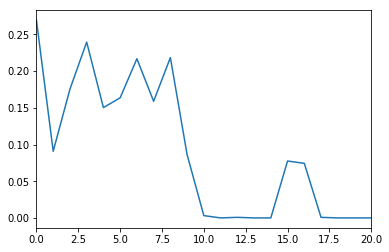

In [72]:
# Just for fun, let's plot it. 
pd.Series(proportionDialogue20).plot()

In [91]:
posProportions = []
posList = ['NOUN', 'VERB', 'ADJ', 'ADV', 'PRON']
for pos in posList: 
    posProportions.append(doByChunks(c.posRepr, 30, (lambda x: x.count(pos)), useProportions=True, equalSized=True))

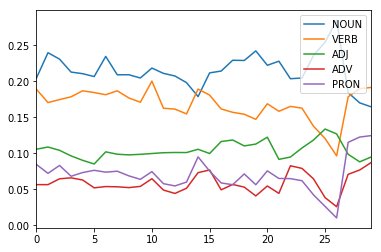

In [92]:
pd.DataFrame(posProportions, index=posList).T.plot()

In [96]:
avgWordsPerSent = doByChunks(c.wordsPerSent, 30, sum, useProportions=True, equalSized=True)

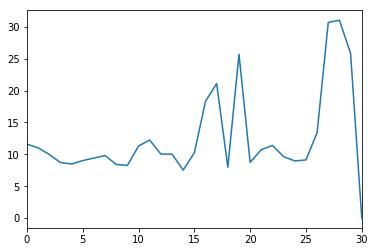

In [98]:
pd.Series(avgWordsPerSent).plot()

In [109]:
episodeLabels = [fn.split('_')[-1].split('.')[0] for fn in filenames]

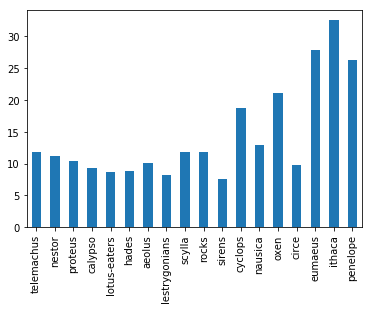

In [111]:
# Words per sentence, by chapter. 
wordsPerSentChaps = [sum(chap.wordsPerSent)/len(chap.wordsPerSent) 
                     for chap in c.chapters]
pd.Series(wordsPerSentChaps, index=episodeLabels).plot(kind='bar')